# Imports

In [1]:
from src.convolution.numerical import self_convolution, convolution
from src.spectrum import (
    LinealEnergySpectrum,
    SpectrumData,
    SpectrumValueType,
    SpecificEnergySpectrum,
    specific_energy_spectum,
    lineal_energy_spectum,
)
from src.paths import project_dir

In [2]:
import numpy as np
import matplotlib

%matplotlib inline
import matplotlib.pylab as plt
from tqdm.notebook import tqdm

In [3]:
!python -V

Python 3.9.8


# Single event spectra for Cs137 (d=1um)

## f1 y spectrum

In [4]:
spectrum_y_f1 = LinealEnergySpectrum.from_csv(
    project_dir / "data" / "interim" / "Cs137_ydy.csv",
    delimiter="\t",
    value_type=SpectrumValueType.ydy,
)
spectrum_y_f1.norm

1.0

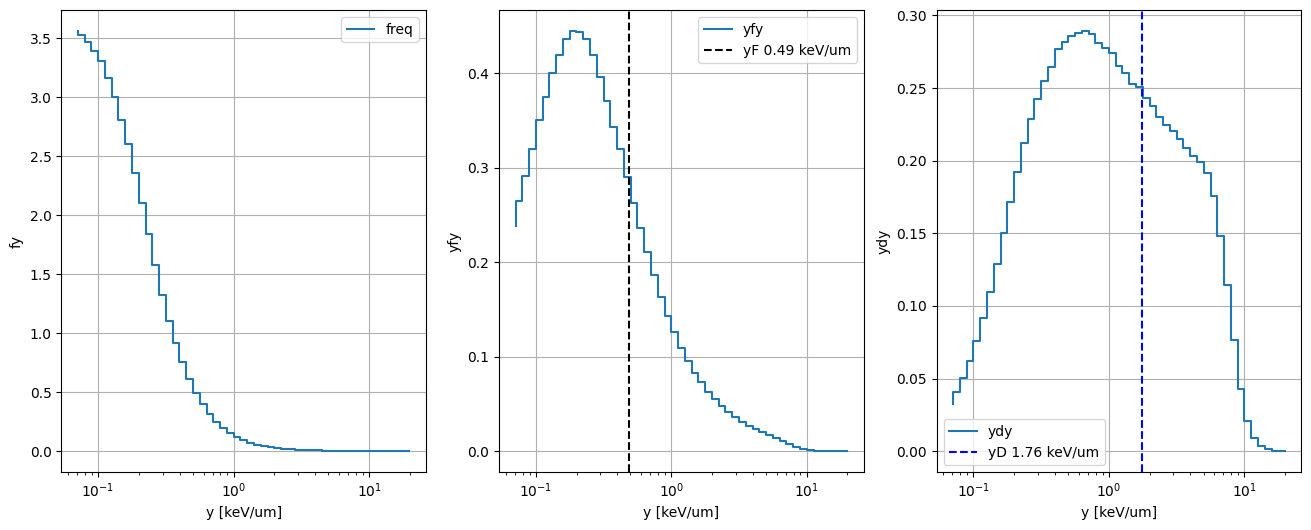

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.fy,
    label="freq",
)
ax[0].set_ylabel("fy")
ax[1].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.yfy,
    label="yfy",
)
ax[1].axvline(
    spectrum_y_f1.yF,
    color="k",
    linestyle="--",
    label=f"yF {spectrum_y_f1.yF:2.2f} keV/um",
)
ax[1].set_ylabel("yfy")
ax[2].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.ydy,
    label="ydy",
)
ax[2].axvline(
    spectrum_y_f1.yD,
    color="b",
    linestyle="--",
    label=f"yD {spectrum_y_f1.yD:2.2f} keV/um",
)
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

## f1 z spectrum

In [6]:
site_diam_um = 1.0
spectrum_z_f1 = specific_energy_spectum(spectrum_y_f1, site_diam_um=site_diam_um)

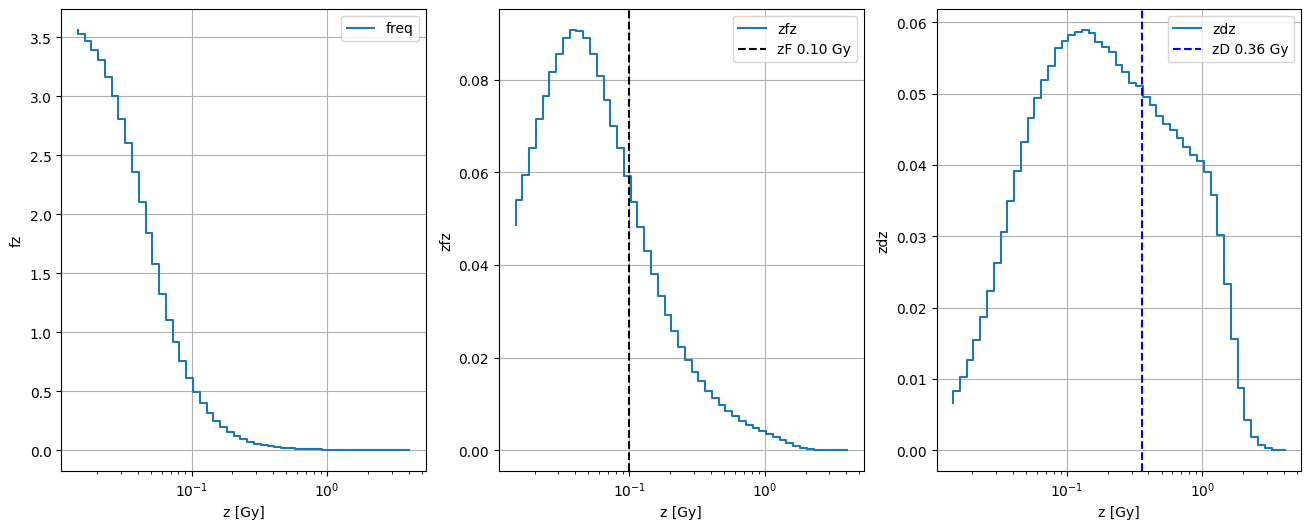

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.fz,
    label="freq",
)
ax[0].set_ylabel("fz")
ax[1].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.zfz,
    label="zfz",
)
ax[1].axvline(
    spectrum_z_f1.zF,
    color="k",
    linestyle="--",
    label=f"zF {spectrum_z_f1.zF:2.2f} Gy",
)
ax[1].set_ylabel("zfz")
ax[2].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.zdz,
    label="zdz",
)
ax[2].axvline(
    spectrum_z_f1.zD,
    color="b",
    linestyle="--",
    label=f"zD {spectrum_z_f1.zD:2.2f} Gy",
)
ax[2].set_ylabel("zdz")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("z [Gy]")
    a.legend()

## convolution f2 = f1*f1 for y

In [8]:
# we apply convolution on f(y), not on yfy or ydy
spectrum_y_f1_function = lambda x: spectrum_y_f1.data.bin_value(
    x, spectrum_value_type=SpectrumValueType.fy
)

expected_f2_domain = (
    spectrum_y_f1.data.bin_edges[0] * 2,
    spectrum_y_f1.data.bin_edges[-1] * 2.0,
)
yvalues_for_f2_convolution = np.geomspace(
    start=expected_f2_domain[0], stop=expected_f2_domain[1], num=100
)

convolution_integration_limits = (
    spectrum_y_f1.data.bin_edges[0] / 8,
    spectrum_y_f1.data.bin_edges[-1] * 8,
)
integral_kwargs = {
    "limit": 800,
    "points": np.geomspace(*convolution_integration_limits, 400),
}
spectrum_y_f2_values_and_errors = [
    self_convolution(
        spectrum_y_f1_function,
        lower_limit=convolution_integration_limits[0],
        upper_limit=convolution_integration_limits[1],
        kwargs=integral_kwargs,
    )(y)
    for y in tqdm(yvalues_for_f2_convolution)
]

  0%|          | 0/100 [00:00<?, ?it/s]

c:\users\legion\workspace\microdosimetric_spectra_folding\src\convolution\numerical.py:66: IntegrationWarning: The maximum number of subdivisions (800) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(


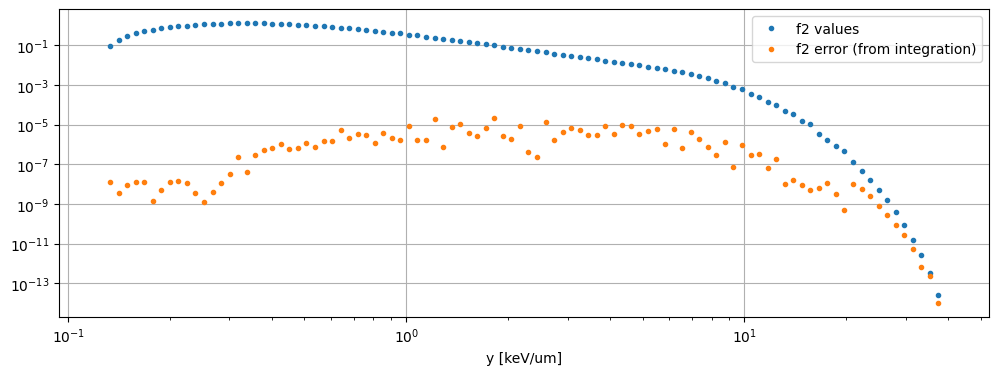

In [9]:
# by comparing the integration error with f2 values we check the numerical integration accuracy
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.plot(
    yvalues_for_f2_convolution,
    [item[0] for item in spectrum_y_f2_values_and_errors],
    ".",
    label="f2 values",
)
ax.plot(
    yvalues_for_f2_convolution,
    [item[1] for item in spectrum_y_f2_values_and_errors],
    ".",
    label="f2 error (from integration)",
)
ax.grid()
ax.set_xlabel("y [keV/um]")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

## f2 y spectrum

In [10]:
spectrum_y_f2 = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=yvalues_for_f2_convolution,
        bin_values_freq=np.array([item[0] for item in spectrum_y_f2_values_and_errors]),
    )
)

In [11]:
spectrum_y_f2.yF, spectrum_y_f2.yD

(0.9757588257150878, 2.24617035824588)

In [12]:
# check if yF is doubled
spectrum_y_f2.yF / spectrum_y_f1.yF

1.9988059638162372

In [13]:
# check norm
spectrum_y_f2.norm

0.9998039842691149

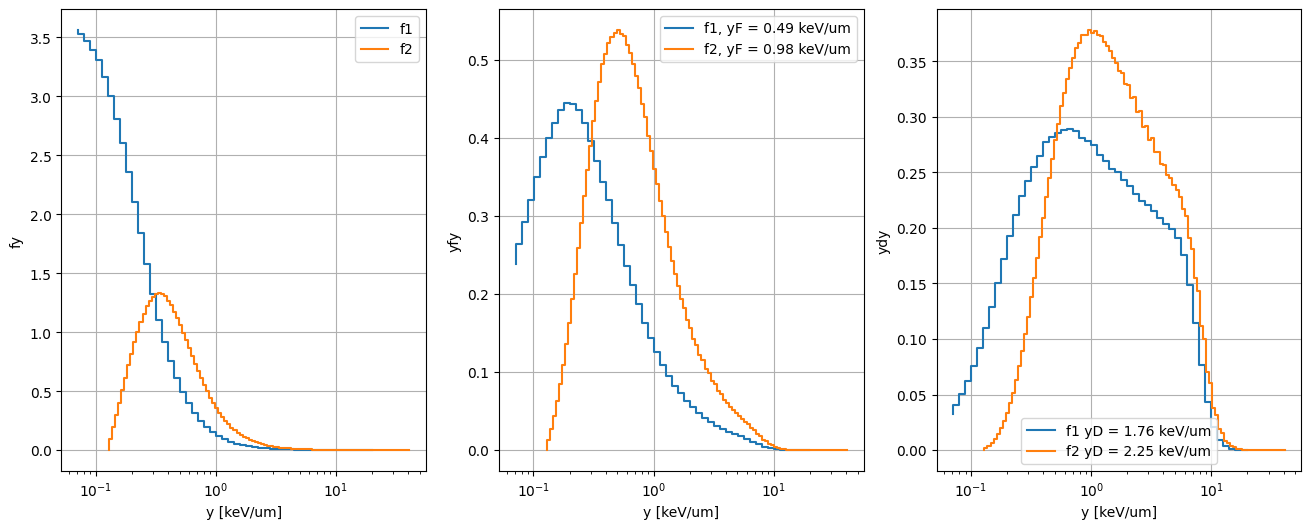

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.fy,
    label="f1",
)
ax[0].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.fy,
    label="f2",
)
ax[0].set_ylabel("fy")
ax[1].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.yfy,
    label=f"f1, yF = {spectrum_y_f1.yF:2.2f} keV/um",
)
ax[1].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.yfy,
    label=f"f2, yF = {spectrum_y_f2.yF:2.2f} keV/um",
)
ax[1].set_ylabel("yfy")
ax[2].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.ydy,
    label=f"f1 yD = {spectrum_y_f1.yD:2.2f} keV/um",
)
ax[2].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.ydy,
    label=f"f2 yD = {spectrum_y_f2.yD:2.2f} keV/um",
)
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

## convolution f3 = f2*f1 for y

In [15]:
# we apply convolution on f(y), not on yfy or ydy
spectrum_y_f2_function = lambda x: spectrum_y_f2.data.bin_value(
    x, spectrum_value_type=SpectrumValueType.fy
)

expected_f3_domain = (
    spectrum_y_f1.data.bin_edges[0] * 2,
    spectrum_y_f2.data.bin_edges[-1] * 2,
)
yvalues_for_f3_convolution = np.geomspace(
    start=expected_f3_domain[0], stop=expected_f3_domain[1], num=100
)

convolution_integration_limits = (
    spectrum_y_f1.data.bin_edges[0] / 8,
    spectrum_y_f2.data.bin_edges[-1] * 8,
)
integral_kwargs = {
    "limit": 800,
    "points": np.geomspace(*convolution_integration_limits, 400),
}
spectrum_y_f3_values_and_errors = [
    convolution(
        spectrum_y_f1_function,
        spectrum_y_f2_function,
        lower_limit=convolution_integration_limits[0],
        upper_limit=convolution_integration_limits[1],
        kwargs=integral_kwargs,
    )(y)
    for y in tqdm(yvalues_for_f3_convolution)
]

  0%|          | 0/100 [00:00<?, ?it/s]

c:\users\legion\workspace\microdosimetric_spectra_folding\src\convolution\numerical.py:99: IntegrationWarning: The maximum number of subdivisions (800) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(


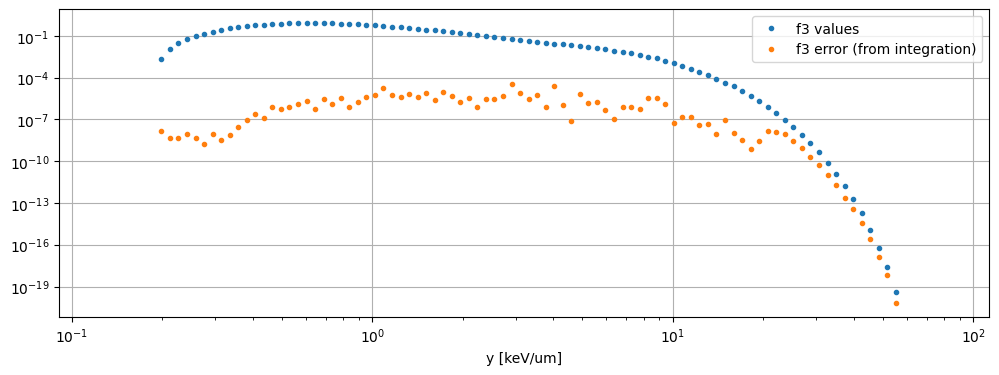

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.plot(
    yvalues_for_f3_convolution,
    [item[0] for item in spectrum_y_f3_values_and_errors],
    ".",
    label="f3 values",
)
ax.plot(
    yvalues_for_f3_convolution,
    [item[1] for item in spectrum_y_f3_values_and_errors],
    ".",
    label="f3 error (from integration)",
)
ax.grid()
ax.set_xlabel("y [keV/um]")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

## f3 y spectrum

In [17]:
spectrum_y_f3 = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=yvalues_for_f3_convolution,
        bin_values_freq=np.array([item[0] for item in spectrum_y_f3_values_and_errors]),
    )
)
spectrum_y_f3.norm, spectrum_y_f3.yF, spectrum_y_f3.yD

(0.9999944072633637, 1.4647158676018, 2.738064412602619)

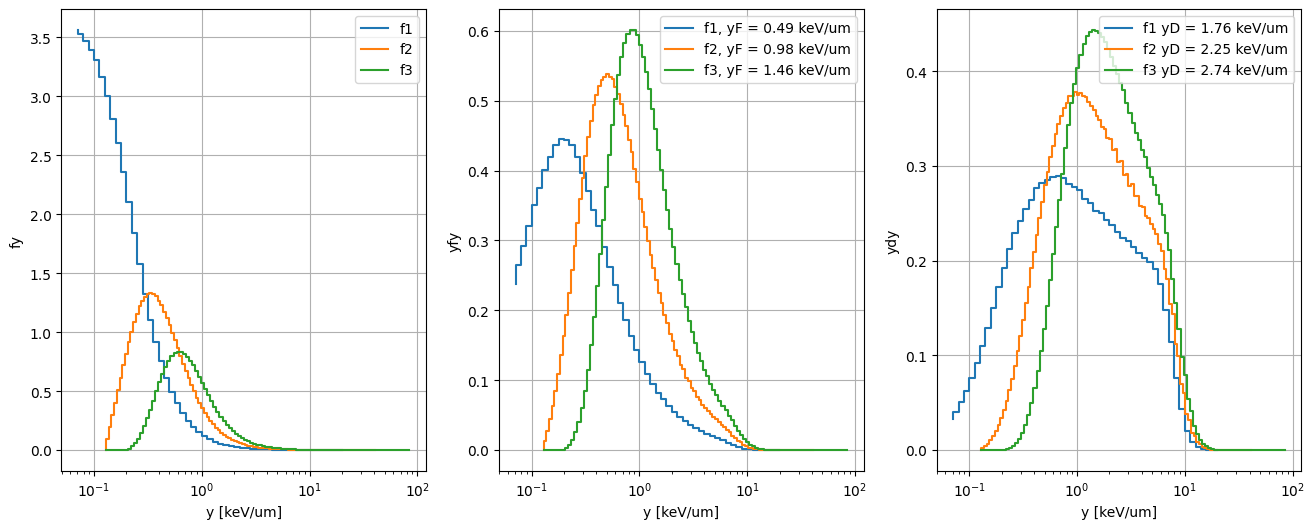

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.fy,
    label="f1",
)
ax[0].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.fy,
    label="f2",
)
ax[0].step(
    spectrum_y_f3.data.bin_edges[1:],
    spectrum_y_f3.fy,
    label="f3",
)
ax[0].set_ylabel("fy")
ax[1].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.yfy,
    label=f"f1, yF = {spectrum_y_f1.yF:2.2f} keV/um",
)
ax[1].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.yfy,
    label=f"f2, yF = {spectrum_y_f2.yF:2.2f} keV/um",
)
ax[1].step(
    spectrum_y_f3.data.bin_edges[1:],
    spectrum_y_f3.yfy,
    label=f"f3, yF = {spectrum_y_f3.yF:2.2f} keV/um",
)
ax[1].set_ylabel("yfy")
ax[2].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.ydy,
    label=f"f1 yD = {spectrum_y_f1.yD:2.2f} keV/um",
)
ax[2].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.ydy,
    label=f"f2 yD = {spectrum_y_f2.yD:2.2f} keV/um",
)
ax[2].step(
    spectrum_y_f3.data.bin_edges[1:],
    spectrum_y_f3.ydy,
    label=f"f3 yD = {spectrum_y_f3.yD:2.2f} keV/um",
)
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

## convolution f4 = f2*f2 for y

In [19]:
expected_f4_domain = (
    spectrum_y_f2.data.bin_edges[0] * 2,
    spectrum_y_f2.data.bin_edges[-1] * 2.0,
)
yvalues_for_f4_convolution = np.geomspace(
    start=expected_f4_domain[0], stop=expected_f4_domain[1], num=100
)

convolution_integration_limits = (
    spectrum_y_f2.data.bin_edges[0] / 8,
    spectrum_y_f2.data.bin_edges[-1] * 8,
)
integral_kwargs = {
    "limit": 800,
    "points": np.geomspace(*convolution_integration_limits, 400),
}
spectrum_y_f4_values_and_errors = [
    self_convolution(
        spectrum_y_f2_function,
        lower_limit=convolution_integration_limits[0],
        upper_limit=convolution_integration_limits[1],
        kwargs=integral_kwargs,
    )(y)
    for y in tqdm(yvalues_for_f4_convolution)
]

  0%|          | 0/100 [00:00<?, ?it/s]

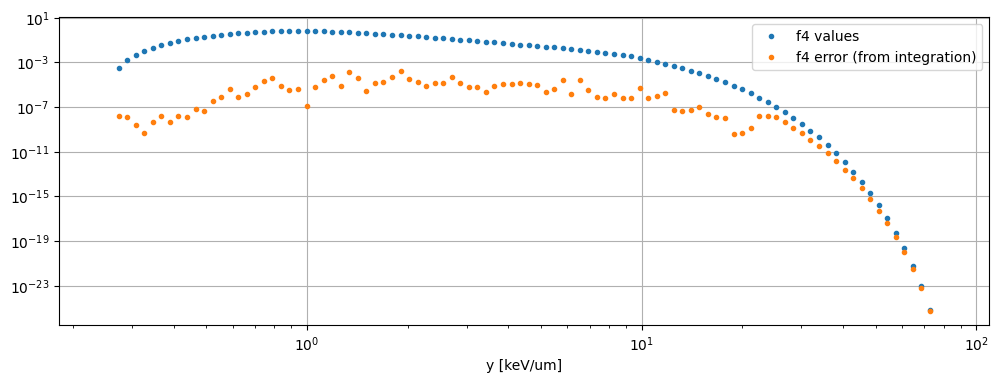

In [20]:
# by comparing the integration error with f2 values we check the numerical integration accuracy
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.plot(
    yvalues_for_f4_convolution,
    [item[0] for item in spectrum_y_f4_values_and_errors],
    ".",
    label="f4 values",
)
ax.plot(
    yvalues_for_f4_convolution,
    [item[1] for item in spectrum_y_f4_values_and_errors],
    ".",
    label="f4 error (from integration)",
)
ax.grid()
ax.set_xlabel("y [keV/um]")
ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

## f4 y spectrum

In [21]:
spectrum_y_f4 = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=yvalues_for_f4_convolution,
        bin_values_freq=np.array([item[0] for item in spectrum_y_f4_values_and_errors]),
    )
)
spectrum_y_f4.norm, spectrum_y_f4.yF, spectrum_y_f4.yD

(0.9998335480589522, 1.9527857374593072, 3.224968561467507)

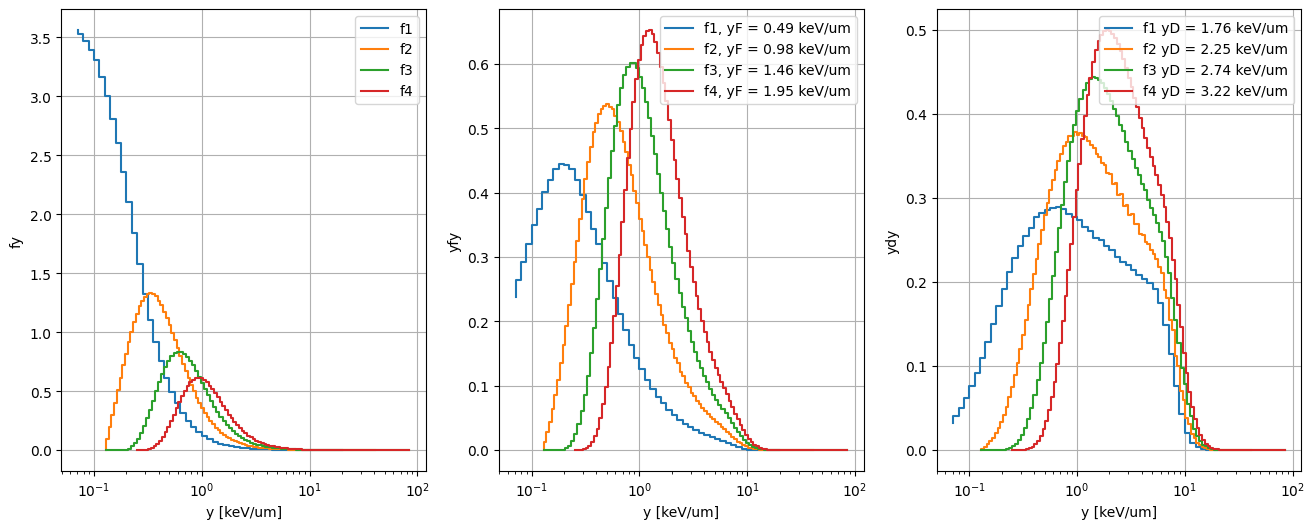

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.fy,
    label="f1",
)
ax[0].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.fy,
    label="f2",
)
ax[0].step(
    spectrum_y_f3.data.bin_edges[1:],
    spectrum_y_f3.fy,
    label="f3",
)
ax[0].step(
    spectrum_y_f4.data.bin_edges[1:],
    spectrum_y_f4.fy,
    label="f4",
)
ax[0].set_ylabel("fy")
ax[1].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.yfy,
    label=f"f1, yF = {spectrum_y_f1.yF:2.2f} keV/um",
)
ax[1].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.yfy,
    label=f"f2, yF = {spectrum_y_f2.yF:2.2f} keV/um",
)
ax[1].step(
    spectrum_y_f3.data.bin_edges[1:],
    spectrum_y_f3.yfy,
    label=f"f3, yF = {spectrum_y_f3.yF:2.2f} keV/um",
)
ax[1].step(
    spectrum_y_f4.data.bin_edges[1:],
    spectrum_y_f4.yfy,
    label=f"f4, yF = {spectrum_y_f4.yF:2.2f} keV/um",
)
ax[1].set_ylabel("yfy")
ax[2].step(
    spectrum_y_f1.data.bin_edges[1:],
    spectrum_y_f1.ydy,
    label=f"f1 yD = {spectrum_y_f1.yD:2.2f} keV/um",
)
ax[2].step(
    spectrum_y_f2.data.bin_edges[1:],
    spectrum_y_f2.ydy,
    label=f"f2 yD = {spectrum_y_f2.yD:2.2f} keV/um",
)
ax[2].step(
    spectrum_y_f3.data.bin_edges[1:],
    spectrum_y_f3.ydy,
    label=f"f3 yD = {spectrum_y_f3.yD:2.2f} keV/um",
)
ax[2].step(
    spectrum_y_f4.data.bin_edges[1:],
    spectrum_y_f4.ydy,
    label=f"f4 yD = {spectrum_y_f4.yD:2.2f} keV/um",
)
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

## f2, f3, f4 z spectrum

In [23]:
spectrum_z_f2 = SpecificEnergySpectrum(
    data=SpectrumData(
        bin_centers=0.204 * spectrum_y_f2.y / site_diam_um**2,
        bin_values_freq=spectrum_y_f2.fy,
    )
)
spectrum_z_f3 = SpecificEnergySpectrum(
    data=SpectrumData(
        bin_centers=0.204 * spectrum_y_f3.y / site_diam_um**2,
        bin_values_freq=spectrum_y_f3.fy,
    )
)
spectrum_z_f4 = SpecificEnergySpectrum(
    data=SpectrumData(
        bin_centers=0.204 * spectrum_y_f4.y / site_diam_um**2,
        bin_values_freq=spectrum_y_f4.fy,
    )
)

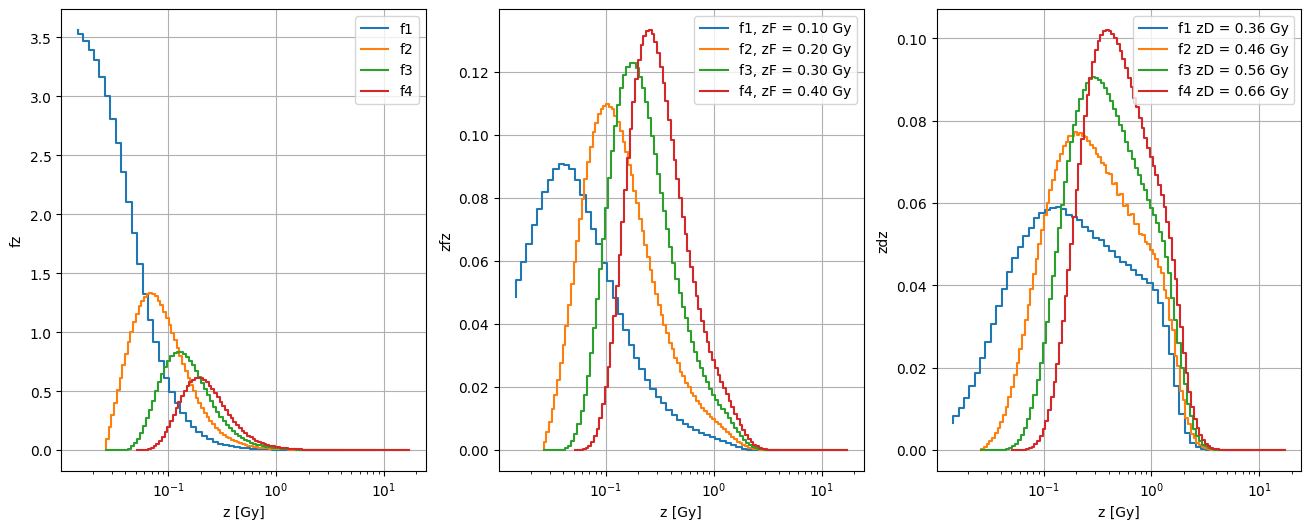

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.fz,
    label="f1",
)
ax[0].step(
    spectrum_z_f2.data.bin_edges[1:],
    spectrum_z_f2.fz,
    label="f2",
)
ax[0].step(
    spectrum_z_f3.data.bin_edges[1:],
    spectrum_z_f3.fz,
    label="f3",
)
ax[0].step(
    spectrum_z_f4.data.bin_edges[1:],
    spectrum_z_f4.fz,
    label="f4",
)
ax[0].set_ylabel("fz")
ax[1].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.zfz,
    label=f"f1, zF = {spectrum_z_f1.zF:2.2f} Gy",
)
ax[1].step(
    spectrum_z_f2.data.bin_edges[1:],
    spectrum_z_f2.zfz,
    label=f"f2, zF = {spectrum_z_f2.zF:2.2f} Gy",
)
ax[1].step(
    spectrum_z_f3.data.bin_edges[1:],
    spectrum_z_f3.zfz,
    label=f"f3, zF = {spectrum_z_f3.zF:2.2f} Gy",
)
ax[1].step(
    spectrum_z_f4.data.bin_edges[1:],
    spectrum_z_f4.zfz,
    label=f"f4, zF = {spectrum_z_f4.zF:2.2f} Gy",
)
ax[1].set_ylabel("zfz")
ax[2].step(
    spectrum_z_f1.data.bin_edges[1:],
    spectrum_z_f1.zdz,
    label=f"f1 zD = {spectrum_z_f1.zD:2.2f} Gy",
)
ax[2].step(
    spectrum_z_f2.data.bin_edges[1:],
    spectrum_z_f2.zdz,
    label=f"f2 zD = {spectrum_z_f2.zD:2.2f} Gy",
)
ax[2].step(
    spectrum_z_f3.data.bin_edges[1:],
    spectrum_z_f3.zdz,
    label=f"f3 zD = {spectrum_z_f3.zD:2.2f} Gy",
)
ax[2].step(
    spectrum_z_f4.data.bin_edges[1:],
    spectrum_z_f4.zdz,
    label=f"f4 zD = {spectrum_z_f4.zD:2.2f} Gy",
)
ax[2].set_ylabel("zdz")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("z [Gy]")
    a.legend()

# Dose dependent  z spectra

In [25]:
D_Gy = 0.05  # Gy (50 mGy)
D_Gy

0.05

In [26]:
# mean number of events in the site
n = D_Gy / spectrum_z_f1.zF
n

0.5020742929431895

In [27]:
# In microdosimetry the low dose is the dose at which sensitive site is affected just once.
# However, since the cells are hit independently, even at low doses target can be hit two or
# more times. Therefore, the statistical criterion for low dose is that 90% of the affected targets
# are hit just once. This happens when D ≤ 0.2 zF .

In [28]:
D_Gy, 0.2 * spectrum_z_f1.zF

(0.05, 0.019917371075462563)

In [29]:
# trying to evaluate n f1(z) + n^2/2 f2(z), we are missing here f0(z)
n, n**2 / 2, n**3 / 6, n**4 / 24

(0.5020742929431895,
 0.12603929781720183,
 0.021093697111542565,
 0.002647650765708883)

In [30]:
z_Gy = np.geomspace(start=1e-2, stop=10, num=300)
spectrum_z_fn_values = (
    n * spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz)
    + n**2
    / 2
    * spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz)
    + n**3
    / 6
    * spectrum_z_f3.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz)
    + n**4
    / 24
    * spectrum_z_f4.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz)
)
spectrum_z_fn_values *= np.exp(-n)

In [31]:
spectrum_z_fn_not_normalized = SpecificEnergySpectrum(
    data=SpectrumData(bin_centers=z_Gy, bin_values_freq=spectrum_z_fn_values),
    site_diam_um=spectrum_z_f1.site_diam_um,
)

In [32]:
spectrum_z_fn = SpecificEnergySpectrum(
    data=SpectrumData(
        bin_centers=spectrum_z_fn_not_normalized.data.bin_centers,
        bin_values_freq=spectrum_z_fn_not_normalized.data.bin_values_freq,
    ),
    site_diam_um=spectrum_z_fn_not_normalized.site_diam_um,
)

In [33]:
spectrum_z_fn.zF, spectrum_z_fn.zD

(0.12679896370793392, 0.4109596994691337)

In [34]:
spectrum_z_fn.norm

0.08017824152407671

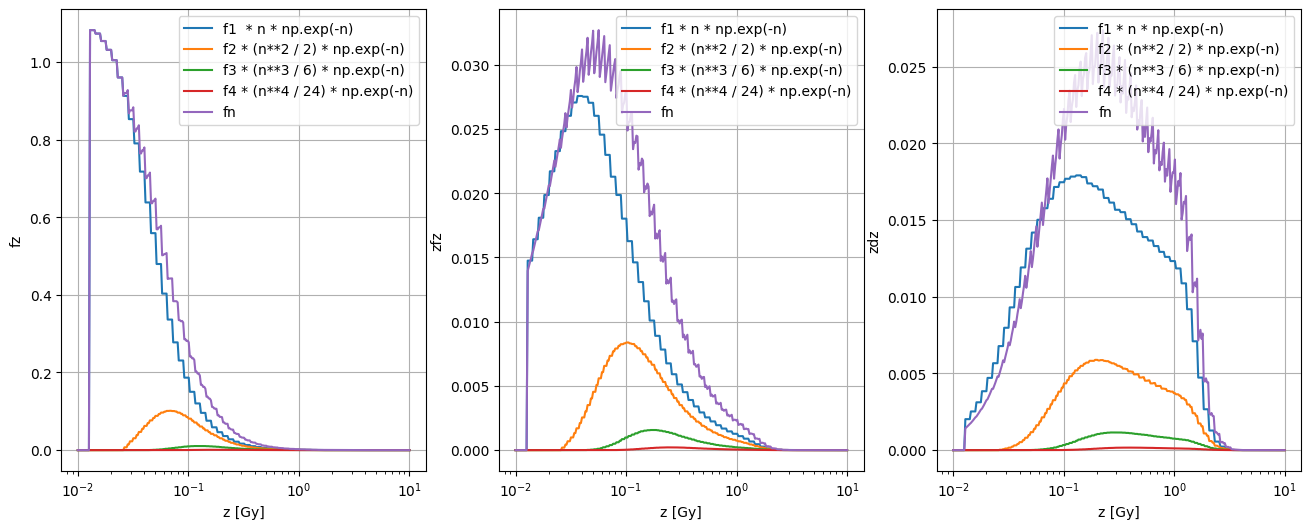

In [35]:
z_Gy = np.geomspace(start=1e-2, stop=10, num=300)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz)
    * n
    * np.exp(-n),
    label="f1  * n * np.exp(-n)",
)
ax[0].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz)
    * (n**2 / 2)
    * np.exp(-n),
    label="f2 * (n**2 / 2) * np.exp(-n)",
)
ax[0].plot(
    z_Gy,
    spectrum_z_f3.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz)
    * (n**3 / 6)
    * np.exp(-n),
    label="f3 * (n**3 / 6) * np.exp(-n)",
)
ax[0].plot(
    z_Gy,
    spectrum_z_f4.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz)
    * (n**4 / 24)
    * np.exp(-n),
    label="f4 * (n**4 / 24) * np.exp(-n)",
)
ax[0].plot(
    z_Gy,
    spectrum_z_fn.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.fz),
    label="fn",
)
ax[0].set_ylabel("fz")
ax[1].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zfz)
    * n
    * np.exp(-n),
    label="f1 * n * np.exp(-n)",
)
ax[1].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zfz)
    * (n**2 / 2)
    * np.exp(-n),
    label="f2 * (n**2 / 2) * np.exp(-n)",
)
ax[1].plot(
    z_Gy,
    spectrum_z_f3.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zfz)
    * (n**3 / 6)
    * np.exp(-n),
    label="f3 * (n**3 / 6) * np.exp(-n)",
)
ax[1].plot(
    z_Gy,
    spectrum_z_f4.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zfz)
    * (n**4 / 24)
    * np.exp(-n),
    label="f4 * (n**4 / 24) * np.exp(-n)",
)
ax[1].plot(
    z_Gy,
    spectrum_z_fn.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zfz),
    label="fn",
)
ax[1].set_ylabel("zfz")
ax[2].plot(
    z_Gy,
    spectrum_z_f1.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zdz)
    * n
    * np.exp(-n),
    label="f1 * n * np.exp(-n)",
)
ax[2].plot(
    z_Gy,
    spectrum_z_f2.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zdz)
    * (n**2 / 2)
    * np.exp(-n),
    label="f2 * (n**2 / 2) * np.exp(-n)",
)
ax[2].plot(
    z_Gy,
    spectrum_z_f3.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zdz)
    * (n**3 / 6)
    * np.exp(-n),
    label="f3 * (n**3 / 6) * np.exp(-n)",
)
ax[2].plot(
    z_Gy,
    spectrum_z_f4.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zdz)
    * (n**4 / 24)
    * np.exp(-n),
    label="f4 * (n**4 / 24) * np.exp(-n)",
)
ax[2].plot(
    z_Gy,
    spectrum_z_fn.data.bin_values(z_Gy, spectrum_value_type=SpectrumValueType.zdz),
    label="fn",
)
ax[2].set_ylabel("zdz")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("z [Gy]")
    a.legend()

In [36]:
spectrum_z_fn.norm

0.08017824152407671

# Dose dependent y spectra

In [37]:
spectrum_y_fn_notnormalized = lineal_energy_spectum(spectrum_z_fn)
spectrum_y_fn_notnormalized.norm

0.3930305957062585

In [38]:
spectrum_y_fn = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=spectrum_y_fn_notnormalized.data.bin_centers,
        bin_values_freq=spectrum_y_fn_notnormalized.data.bin_values_freq
        / spectrum_y_fn_notnormalized.norm,
    )
)
spectrum_y_fn.norm

0.9999999999999999

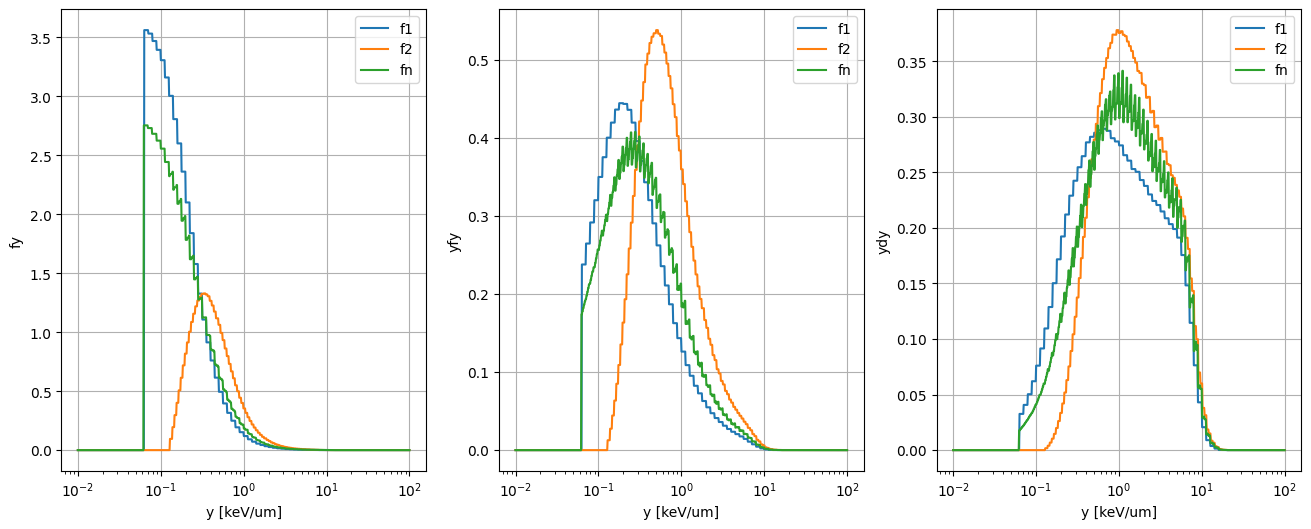

In [39]:
y_keV_um = np.geomspace(start=1e-2, stop=1e2, num=800)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(
    y_keV_um,
    spectrum_y_f1.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.fy),
    label="f1",
)
ax[0].plot(
    y_keV_um,
    spectrum_y_f2.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.fy),
    label="f2",
)
ax[0].plot(
    y_keV_um,
    spectrum_y_fn.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.fy),
    label="fn",
)
ax[0].set_ylabel("fy")
ax[1].plot(
    y_keV_um,
    spectrum_y_f1.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.yfy),
    label="f1",
)
ax[1].plot(
    y_keV_um,
    spectrum_y_f2.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.yfy),
    label="f2",
)
ax[1].plot(
    y_keV_um,
    spectrum_y_fn.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.yfy),
    label="fn",
)
ax[1].set_ylabel("yfy")
ax[2].plot(
    y_keV_um,
    spectrum_y_f1.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.ydy),
    label="f1",
)
ax[2].plot(
    y_keV_um,
    spectrum_y_f2.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.ydy),
    label="f2",
)
ax[2].plot(
    y_keV_um,
    spectrum_y_fn.data.bin_values(y_keV_um, spectrum_value_type=SpectrumValueType.ydy),
    label="fn",
)
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

In [40]:
spectrum_y_f1.yF, spectrum_y_f2.yF, spectrum_y_fn.yF

(0.48817085969270974, 0.9757588257150878, 0.6215635475879115)

In [41]:
from src.probability import cfds_with_progress

y_keV_um = np.geomspace(start=1e-1, stop=1e1, num=100)
integral_kwargs = {"limit": 2000}
# integral_kwargs = {}
cfds_y_fn_with_errors = cfds_with_progress(
    y_keV_um, spectrum_y_fn.data, include_error=True, kwargs=integral_kwargs
)

Processing:  69%|██████▉   | 69/100 [00:45<00:41,  1.34s/it]c:\users\legion\workspace\microdosimetric_spectra_folding\src\convolution\numerical.py:36: IntegrationWarning: The maximum number of subdivisions (2000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = quad(func=func, a=lower_limit, b=upper_limit, args=args, **kwargs)
Processing: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


(0.9, 1.0445917914474065)

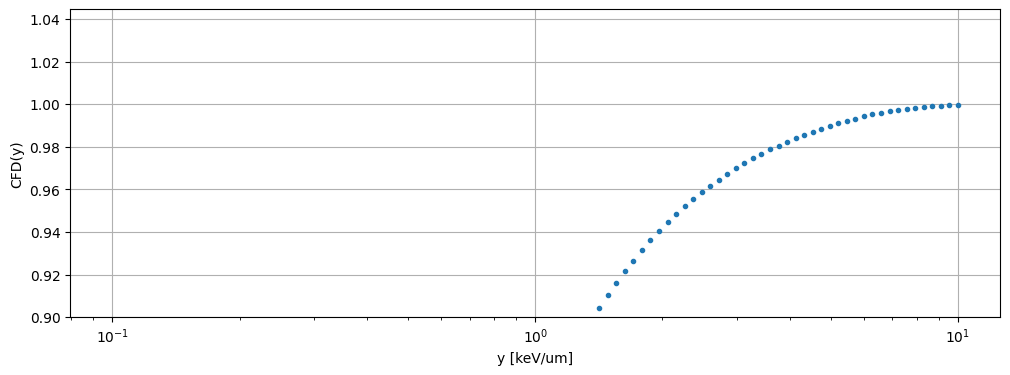

In [42]:
fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.errorbar(
    y_keV_um, cfds_y_fn_with_errors[:, 0], yerr=cfds_y_fn_with_errors[:, 1], fmt="."
)
ax.grid()
ax.set_xscale("log")
ax.set_xlabel("y [keV/um]")
ax.set_ylabel("CFD(y)")
ax.set_ylim(0.9, None)